In [1]:
import os
import openslide
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import cv2 as cv
import pandas as pd
from matplotlib import cm
from statannot import add_stat_annotation
cmap = cm.get_cmap()
from skimage.segmentation import (morphological_chan_vese,
                                  morphological_geodesic_active_contour,
                                  inverse_gaussian_gradient,
                                  checkerboard_level_set)
from skimage.filters import threshold_minimum, threshold_otsu,gaussian
from skimage import morphology
from skimage.transform import rescale, resize, downscale_local_mean
import PIL.ImageDraw as ImageDraw
import PIL.Image as Image

### Functions for reading `.xml` annotations (ground truth provided by experts)

In [2]:
def read_camelyon_annotation(xml_path):
    root = ET.parse(xml_path)
    Annotations_tumor = []
    Annotations_exclusion = []
    for i in root.iter('Annotation'):
        Annotation = []
        for j in i.iter('Coordinate'):
            Annotation.append((float(j.attrib['X']),float(j.attrib['Y'])))
        if i.attrib['PartOfGroup'] == '_0' or i.attrib['PartOfGroup'] == '_1' or i.attrib['PartOfGroup'] == 'Tumor' or i.attrib['PartOfGroup'] == 'Metastases':
            Annotations_tumor.append(Annotation)
        elif i.attrib['PartOfGroup'] == '_2' or i.attrib['PartOfGroup'] == 'exclusion':
            Annotations_exclusion.append(Annotation)
    return Annotations_tumor,Annotations_exclusion
def read_paip2019_annotation(xml_path):
    root = ET.parse(xml_path)
    Annotations = {'whole_tumor':[],
                   'viable_tumor':[],
                   'ignore':[]}
    for a in root.iter('Annotation'):
        for r in a.iter('Region'):
            Annotation = []
            for v in r.iter('Vertex'):
                Annotation.append((float(v.attrib['X']), float(v.attrib['Y'])))
            if a.attrib['Id']== '1':
                Annotations['whole_tumor'].append(Annotation)
            if a.attrib['Id']== '2' and r.attrib['NegativeROA']== '0':
                Annotations['viable_tumor'].append(Annotation)
            if a.attrib['Id']== '2' and r.attrib['NegativeROA']== '1':
                Annotations['ignore'].append(Annotation)
    return Annotations
def read_paip2020_annotation(xml_path):
    root = ET.parse(xml_path)
    Annotations = []
    for a in root.iter('Annotation'):
        for r in a.iter('Region'):
            Annotation = []
            for v in r.iter('Vertex'):
                Annotation.append((float(v.attrib['X']), float(v.attrib['Y'])))
            Annotations.append(Annotation)
    return Annotations

### Functions for creating masks (tissue mask, label mask)

In [3]:
# Identify tissue regions
def HSV_otsu(img,channels=['H','S']):
    img = np.array(img)[:,:,:3]
    hsv = cv.cvtColor(img,cv.COLOR_BGR2HSV)
    if 'H' in channels:
        _,mask_H = cv.threshold(hsv[:,:,0],0,179,cv.THRESH_BINARY+cv.THRESH_OTSU)
        mask_H = mask_H != 0
    else:
        mask_H = np.ones((img.shape[0],img.shape[1]),dtype=bool)
    if 'S' in channels:
        _,mask_S = cv.threshold(hsv[:,:,1],0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
        mask_S = mask_S != 0
    else:
        mask_S = np.ones((img.shape[0],img.shape[1]),dtype=bool)
    if 'V' in channels:
        _,mask_V = cv.threshold(hsv[:,:,2],0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
        mask_V = mask_V != 0
    else:
        mask_V = np.ones((img.shape[0],img.shape[1]),dtype=bool)
    mask = np.logical_and(mask_H,mask_S,mask_V).astype(np.uint8)
    return mask
def GRAY_otsu(img,histeq=False):
    img = np.array(img)[:,:,:3]
    gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    if histeq:
        clahe =  cv.createCLAHE(clipLimit=40, tileGridSize=(8,8))
        gray = clahe.apply(gray)
    otsu_threshold,mask = cv.threshold(gray,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
    mask = (mask == 0).astype(np.uint8)
    return mask
def binary_PAIP(img,threshold = [235, 210, 235]):
    mask_R = img[:,:,0]<threshold[0]
    mask_G = img[:,:,1]<threshold[1]
    mask_B= img[:,:,2]<threshold[2]
    mask = np.logical_and(mask_R,mask_G,mask_B).astype(np.uint8)
    return mask        

# Crop boundary of WSI
def crop_boundary(img, boundary_ratio=[0,0,0,0]):
    # boundary_ratio: 
    boundary_ratio_u = boundary_ratio[0]
    boundary_ratio_b = boundary_ratio[1]
    boundary_ratio_l = boundary_ratio[2]
    boundary_ratio_r = boundary_ratio[3]
    NROW,NCOL = img.shape
    img[:int(NROW*boundary_ratio_u),:]=0
    if boundary_ratio_b!=0:
        img[-int(NCOL*boundary_ratio_b):,:]=0
    img[:,:int(NROW*boundary_ratio_l)]=0
    if boundary_ratio_r!=0:
        img[:,-int(NCOL*boundary_ratio_r):]=0
    return img

# Generate label mask from boundary coordinates
def create_tumor_mask(slide_ob,Annotations,downsample_scale):
    mask =  Image.new('1', (int(np.round(slide_ob.dimensions[0]/downsample_scale)),int(np.round(slide_ob.dimensions[1]/downsample_scale))))
    draw = ImageDraw.Draw(mask)
    for i in range(len(Annotations[0])):
        Annotation = Annotations[0][i]
        Annotation = [(i[0]/downsample_scale,i[1]/downsample_scale) for i in Annotation]
        draw.polygon(Annotation,fill=1,outline=0)
    for i in range(len(Annotations[1])):
        Annotation = Annotations[1][i]
        Annotation = [(i[0]/downsample_scale,i[1]/downsample_scale) for i in Annotation]
        draw.polygon(Annotation,fill=0,outline=0)
    #mask = np.array(mask.resize((int(slide_ob.dimensions[0]/downsample_scale), int(slide_ob.dimensions[1]/downsample_scale))))
    mask = np.array(mask)
    mask = (mask == 1).astype(np.uint8)
    return mask

### Function for evaluating predicted results

In [4]:
def evaulate_coarse(accurate, coarse, tissue):
    overall = len(np.where(tissue==1)[0])
    tp = len(np.where((accurate==1)&(coarse==1)&(tissue==1))[0])
    fp = len(np.where((accurate!=1)&(coarse==1)&(tissue==1))[0])
    tn = len(np.where((accurate==0)&(coarse==0)&(tissue==1))[0])
    fn = len(np.where((accurate!=0)&(coarse==0)&(tissue==1))[0])
#     print(tp,fp,tn,fn)
    if tp+fp+tn+fn == overall:
        if tp+fp == 0:
            ppv = np.nan
            tpr = np.nan
        else:
            ppv = tp/(tp+fp)
            tpr = tp/(tp+fn)
        if tn+fn == 0:
            npv = np.nan
            tnr = np.nan
        else:
            npv = tn/(tn+fn)
            tnr = tn/(tn+fp)
        if tpr+ppv != 0:
            f1 = 2*tpr*ppv/(tpr+ppv)
        else:
            f1 = np.nan
        
        accuracy = (tp+tn)/overall
#         print("f1:",f1)
        return ppv,npv,tpr,tnr,f1, accuracy
    else:
        print(tp,fp,tn,fn,fn+tp+fp+tn,overall)
        print("Error happens in calculating metrics!")
        return None

### Read slide, coarse annotations, and ground truth annotations

/cis/home/zwang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: No contour levels were found within the data range.
  app.launch_new_instance()
/cis/home/zwang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: No contour levels were found within the data range.


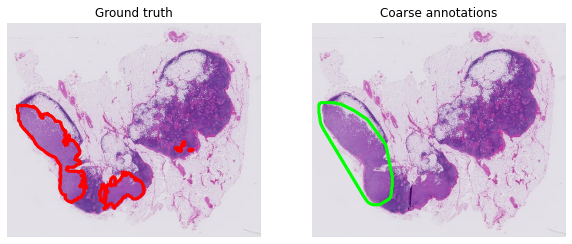

In [5]:
unit = 256
slide_ob = openslide.OpenSlide('/cis/net/gaon1/data/zwang/camelyon/target/slides/test_016.tif')
annots_accurate =  read_camelyon_annotation('ground_truth.xml')
with open("coarse_annotations.sav",'rb') as handle:
    CA = pickle.load(handle)
handle.close()     
annots_coarse = [CA['test_016']['annotations_outer'],CA['test_016']['annotations_inner']]
    
boundary_ratio = [0,0,0,0]  
mask_accurate = np.array(crop_boundary(create_tumor_mask(slide_ob,annots_accurate, unit),boundary_ratio),dtype=np.uint8)    
mask_coarse = np.array(crop_boundary(create_tumor_mask(slide_ob,annots_coarse,unit),boundary_ratio),dtype=np.uint8)   
thumbnail = np.array(slide_ob.get_thumbnail((mask_accurate.shape[1],mask_accurate.shape[0])))[:,:,:3]

f, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(thumbnail)
ax[0].contour(mask_accurate,[0],linewidths=3,colors = 'red')
ax[1].imshow(thumbnail)
ax[1].contour(mask_coarse,[0],linewidths=3,colors = 'lime')
ax[0].set_title('Ground truth')
ax[1].set_title('Coarse annotations')
ax[0].set_axis_off()
ax[1].set_axis_off()

### Post-process the predicted heatmap

/cis/home/zwang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: No contour levels were found within the data range.
/cis/home/zwang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: No contour levels were found within the data range.
/cis/home/zwang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: No contour levels were found within the data range.
/cis/home/zwang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: No contour levels were found within the data range.


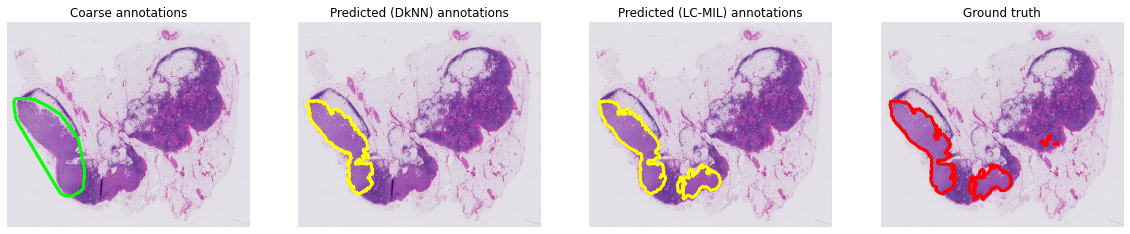

In [9]:
# DkNN
remove_size = 100 # remove any objects smaller than 100 pixel
fill_size = 100 # fill in any holes smaller than 100 pixel
heatmap = np.load('DkNN/heatmap_test_016.npy')
heatmap_predicted = np.zeros_like(heatmap)
heatmap_predicted[heatmap>0] = heatmap[heatmap>0]
mask_predicted_1 = morphology.remove_small_holes(morphology.remove_small_objects(heatmap_predicted>0, remove_size), fill_size)  

# LC-MIL
v0 = 0.6 # threshold on predicted score
remove_size = 100 # remove any objects smaller than 100 pixel
fill_size = 100 # fill in any holes smaller than 100 pixel
heatmap = np.load('LC_MIL/heatmap_test_016.npy')
heatmap_predicted = np.zeros_like(heatmap)
heatmap_predicted[heatmap>0] = heatmap[heatmap>0]
heatmap_blur = gaussian(heatmap_predicted,sigma=1)
mask_predicted_2 = morphology.remove_small_holes(morphology.remove_small_objects(heatmap_blur > v0, remove_size), fill_size)  

f, ax = plt.subplots(1,4,figsize=(20,5))
ax[0].imshow(thumbnail)
ax[0].contour(mask_coarse,[0],linewidths=3,colors = 'lime')
ax[0].set_title('Coarse annotations')

ax[1].imshow(thumbnail)
ax[1].contour(mask_predicted_1,[0],linewidths=3,colors = 'yellow')
ax[1].set_title('Predicted (DkNN) annotations')

ax[2].imshow(thumbnail)
ax[2].contour(mask_predicted_2,[0],linewidths=3,colors = 'yellow')
ax[2].set_title('Predicted (LC-MIL) annotations')

ax[3].imshow(thumbnail)
ax[3].contour(mask_accurate,[0],linewidths=3,colors = 'red')
ax[3].set_title('Ground truth')

ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()
ax[3].set_axis_off()

### Quantitative results

In [12]:
mask_tissue = crop_boundary(HSV_otsu(thumbnail),boundary_ratio)
ppv_c,npv_c,tpr_c,tnr_c,f1_c, accuracy_c = evaulate_coarse(mask_accurate, mask_coarse, mask_tissue)
print('Coarse annotations: PPV = {:.3f}, TPR={:.3f}, F1 = {:.3f}, Accuracy = {:.3f}'.format(ppv_c,tpr_c,f1_c, accuracy_c))

ppv_r,npv_r,tpr_r,tnr_r,f1_r, accuracy_r = evaulate_coarse(mask_accurate, mask_predicted_1, mask_tissue)
print('Refined (DkNN):     PPV = {:.3f}, TPR={:.3f}, F1 = {:.3f}, Accuracy = {:.3f}'.format(ppv_r,tpr_r,f1_r, accuracy_r))      

ppv_r,npv_r,tpr_r,tnr_r,f1_r, accuracy_r = evaulate_coarse(mask_accurate, mask_predicted_2, mask_tissue)
print('Refined (LC-MIL):   PPV = {:.3f}, TPR={:.3f}, F1 = {:.3f}, Accuracy = {:.3f}'.format(ppv_r,tpr_r,f1_r, accuracy_r))    

Coarse annotations: PPV = 0.818, TPR=0.748, F1 = 0.782, Accuracy = 0.890
Refined (DkNN):     PPV = 0.946, TPR=0.729, F1 = 0.823, Accuracy = 0.917
Refined (LC-MIL):   PPV = 0.958, TPR=0.951, F1 = 0.954, Accuracy = 0.976
